# Análisis de Autos Usados CORE 
## Felipe Lucciano Santino Di Vanni Valenzuela

### Objetivo del Análisis
Este proyecto tiene como objetivo analizar un dataset de autos usados de Craigslist para desarrollar un modelo predictivo de precios. El análisis incluye:
- Exploración detallada de datos
- Preprocesamiento y limpieza
- Modelado predictivo (Linear Regression y Random Forest)
- Optimización de modelos

### Dataset
- **Fuente**: [Craigslist Cars & Trucks Data](https://www.kaggle.com/datasets/austinreese/craigslist-carstrucks-data)
- **Contenido**: Anuncios de vehículos usados en Craigslist
- **Objetivo**: Predecir precios de vehículos basados en sus características


## Requisitos del Proyecto

### 1. Carga y Exploración de Datos:
- Descargar y cargar el dataset
- Realizar una exploración inicial para entender la estructura del dataset
- Identificar valores faltantes, duplicados y outliers

### 2. Limpieza y Preprocesamiento:
- Manejar valores faltantes
- Eliminar duplicados
- Corregir inconsistencias en los datos categóricos
- Escalar las características numéricas
- Realizar transformaciones necesarias para las características categóricas

### 3. Exploración de Datos:
- Crear visualizaciones univariadas y multivariadas
- Calcular estadísticas descriptivas

### 4. Modelado y Evaluación:
- Implementar al menos dos modelos de regresión (Linear Regression y Random Forest Regressor)
- Evaluar los modelos utilizando MSE, RMSE, y R^2
- Seleccionar el mejor modelo basado en las métricas de evaluación

### 5. Optimización del Modelo:
- Optimizar el modelo seleccionado utilizando GridSearchCV

### 6. Documentación y Entrega:
- Documentar todo el proceso en un archivo .ipynb claramente comentado
- Crear visualizaciones con interpretaciones
- Subir el archivo a un repositorio en GitHub con un tag de liberación


In [1]:
# Importaciones necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


In [2]:
# Carga del dataset
df = pd.read_csv('../data/vehicles.csv')

# Análisis inicial de duplicados
duplicadosCount = df.duplicated().sum()
porcentajeDuplicados = (duplicadosCount / len(df)) * 100

# Información básica del dataset
infoDataset = {
    'registrosTotales': len(df),
    'caracteristicas': len(df.columns),
    'duplicadosEncontrados': duplicadosCount,
    'porcentajeDuplicados': f"{porcentajeDuplicados:.2f}%"
}

print(f"Registros totales: {infoDataset['registrosTotales']:,}")
print(f"Características: {infoDataset['caracteristicas']}")
print(f"Duplicados: {infoDataset['duplicadosEncontrados']:,} ({infoDataset['porcentajeDuplicados']})")


Registros totales: 426,880
Características: 26
Duplicados: 0 (0.00%)


## 1. Exploración Inicial de Datos

### 1.1 Información Básica del Dataset
Comenzamos analizando la estructura general del dataset para entender qué tipo de información tenemos disponible y su calidad.

### 1.2 Análisis de Valores Faltantes
Los valores faltantes pueden impactar significativamente el rendimiento del modelo, por lo que es crucial identificarlos y desarrollar estrategias para manejarlos adecuadamente.


Análisis de valores faltantes:
              ValoresFaltantes  Porcentaje
county                  426880  100.000000
size                    306361   71.767476
cylinders               177678   41.622470
condition               174104   40.785232
VIN                     161042   37.725356
drive                   130567   30.586347
paint_color             130203   30.501078
type                     92858   21.752717
manufacturer             17646    4.133714
title_status              8242    1.930753


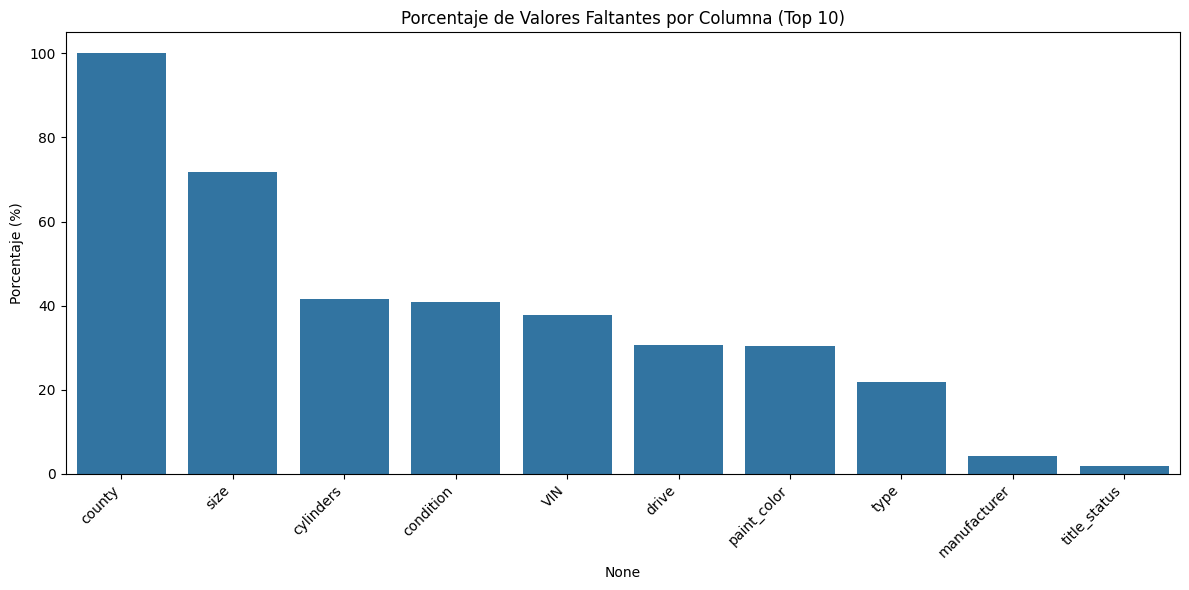

In [3]:
# Análisis de valores faltantes
def analizarValoresFaltantes(dataFrame):
    """
    Analiza valores faltantes en el dataset y calcula porcentajes
    """
    valoresFaltantes = dataFrame.isnull().sum()
    porcentajeFaltante = (valoresFaltantes / len(dataFrame)) * 100
    analisisFaltantes = pd.DataFrame({
        'ValoresFaltantes': valoresFaltantes,
        'Porcentaje': porcentajeFaltante
    }).sort_values('Porcentaje', ascending=False)
    return analisisFaltantes[analisisFaltantes['ValoresFaltantes'] > 0]

analisisFaltantes = analizarValoresFaltantes(df)
print("Análisis de valores faltantes:")
print(analisisFaltantes.head(10))

# Visualización de valores faltantes
plt.figure(figsize=(12, 6))
topFaltantes = analisisFaltantes.head(10)
sns.barplot(x=topFaltantes.index, y=topFaltantes['Porcentaje'])
plt.xticks(rotation=45, ha='right')
plt.title('Porcentaje de Valores Faltantes por Columna (Top 10)')
plt.ylabel('Porcentaje (%)')
plt.tight_layout()
plt.show()


## 2. Análisis Exploratorio de Datos (EDA)

### 2.1 Distribución de Variables Numéricas
Analizamos la distribución de las principales variables numéricas para identificar patrones, sesgos y posibles outliers que puedan afectar el rendimiento de nuestros modelos.


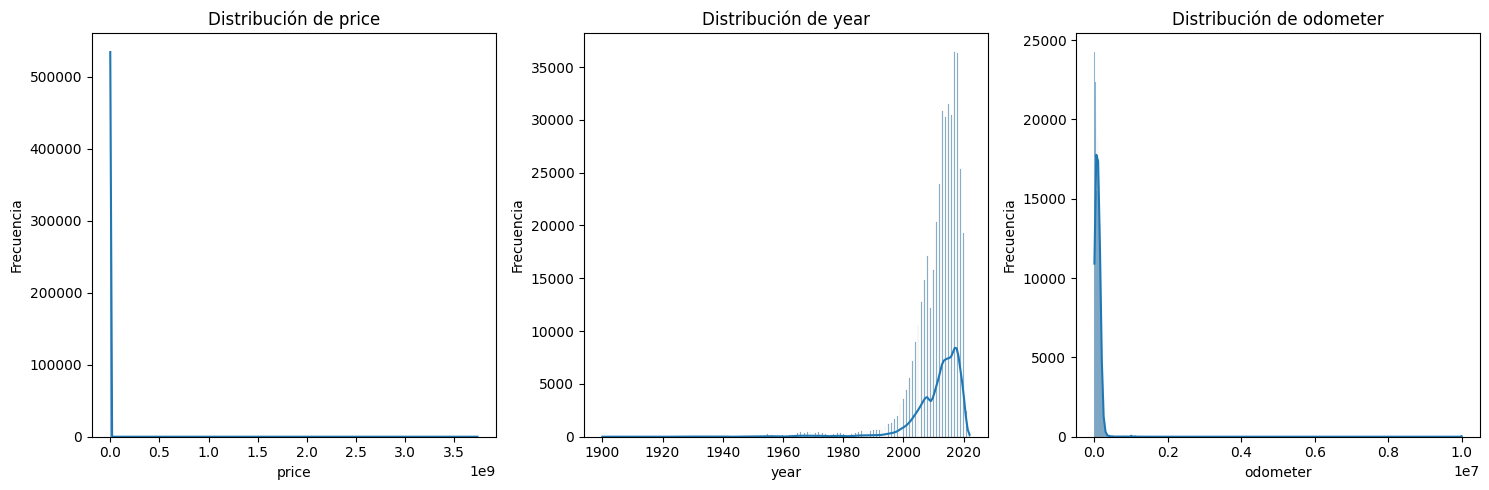


Estadísticas descriptivas de variables numéricas:
              price           year      odometer
count  4.268800e+05  425675.000000  4.224800e+05
mean   7.519903e+04    2011.235191  9.804333e+04
std    1.218228e+07       9.452120  2.138815e+05
min    0.000000e+00    1900.000000  0.000000e+00
25%    5.900000e+03    2008.000000  3.770400e+04
50%    1.395000e+04    2013.000000  8.554800e+04
75%    2.648575e+04    2017.000000  1.335425e+05
max    3.736929e+09    2022.000000  1.000000e+07


In [4]:
# Análisis de distribuciones de variables numéricas
columnasNumericas = ['price', 'year', 'odometer']

# Crear visualizaciones de distribuciones
plt.figure(figsize=(15, 5))
for idx, columna in enumerate(columnasNumericas, 1):
    plt.subplot(1, 3, idx)
    sns.histplot(data=df, x=columna, kde=True)
    plt.title(f'Distribución de {columna}')
    plt.xlabel(columna)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

# Estadísticas descriptivas
print("\nEstadísticas descriptivas de variables numéricas:")
print(df[columnasNumericas].describe())


### 2.2 Análisis de Outliers
Los outliers pueden afectar significativamente el rendimiento de los modelos, especialmente la regresión lineal. Es importante identificarlos y decidir cómo manejarlos.


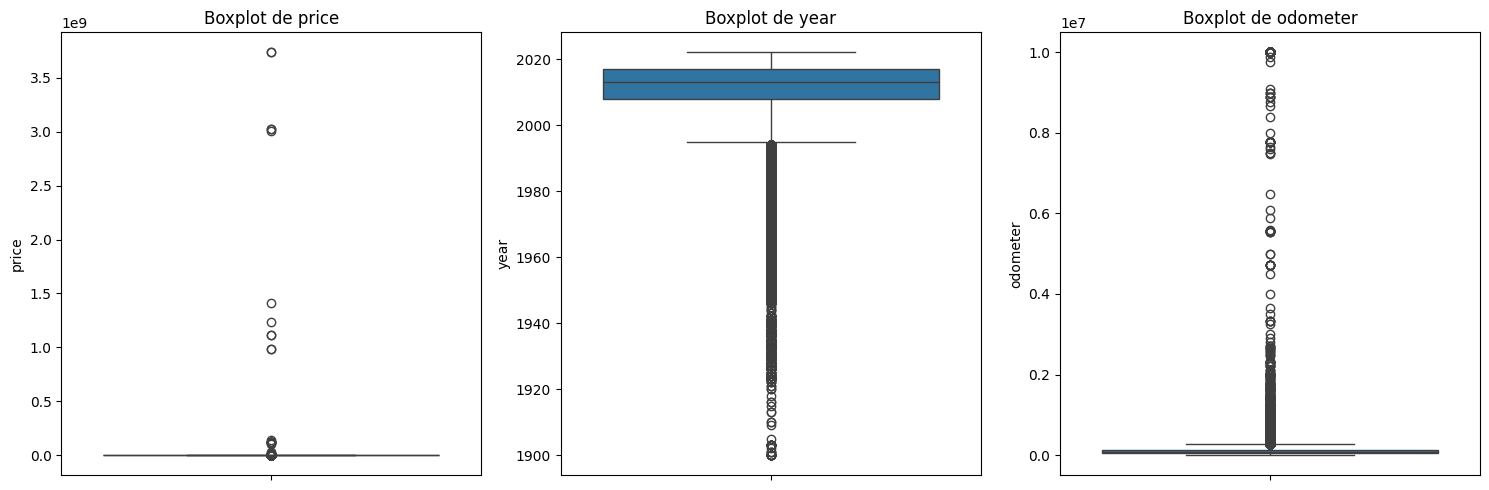

Análisis de outliers usando método IQR:
price: 8,177 outliers (1.92%)
year: 15,896 outliers (3.72%)
odometer: 4,385 outliers (1.03%)


In [5]:
# Boxplots para identificar outliers
plt.figure(figsize=(15, 5))
for idx, columna in enumerate(columnasNumericas, 1):
    plt.subplot(1, 3, idx)
    sns.boxplot(y=df[columna])
    plt.title(f'Boxplot de {columna}')
plt.tight_layout()
plt.show()

# Análisis cuantitativo de outliers usando método IQR
print("Análisis de outliers usando método IQR:")
infoOutliers = {}
for columna in columnasNumericas:
    if columna in df.columns:
        Q1 = df[columna].quantile(0.25)
        Q3 = df[columna].quantile(0.75)
        IQR = Q3 - Q1
        limiteSuperior = Q3 + 1.5 * IQR
        limiteInferior = Q1 - 1.5 * IQR
        
        outliers = df[(df[columna] < limiteInferior) | (df[columna] > limiteSuperior)]
        porcentajeOutliers = (len(outliers) / len(df)) * 100
        
        infoOutliers[columna] = {
            'cantidad': len(outliers),
            'porcentaje': porcentajeOutliers
        }
        
        print(f"{columna}: {len(outliers):,} outliers ({porcentajeOutliers:.2f}%)")


## 3. Limpieza y Preprocesamiento de Datos

### 3.1 Eliminación de Duplicados y Columnas Irrelevantes
Comenzamos eliminando duplicados y columnas que no aportan valor predictivo para mejorar la calidad del dataset.


In [6]:
# Eliminar duplicados
dfLimpio = df.drop_duplicates()
duplicadosEliminados = len(df) - len(dfLimpio)

print(f"Duplicados eliminados: {duplicadosEliminados:,}")
print(f"Registros restantes: {len(dfLimpio):,}")

# Eliminar columnas irrelevantes para predicción
columnasEliminar = [
    'url', 'region_url', 'image_url', 'description', 
    'posting_date', 'id', 'county', 'VIN'
]

# Verificar que las columnas existen antes de eliminar
columnasExistentes = [col for col in columnasEliminar if col in dfLimpio.columns]
dfLimpio = dfLimpio.drop(columns=columnasExistentes)

print(f"Columnas eliminadas: {len(columnasExistentes)}")
print(f"Columnas restantes: {len(dfLimpio.columns)}")
print(f"Columnas disponibles: {list(dfLimpio.columns)}")


Duplicados eliminados: 0
Registros restantes: 426,880
Columnas eliminadas: 8
Columnas restantes: 18
Columnas disponibles: ['region', 'price', 'year', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color', 'state', 'lat', 'long']


### 3.2 Manejo Inteligente de Valores Faltantes
Aplicamos estrategias específicas de imputación según el tipo de variable y el porcentaje de valores faltantes para maximizar la calidad de los datos.


In [7]:
# Función para imputación inteligente de variables numéricas
def imputacionNumericaInteligente(dataFrame, columnaObjetivo, columnasGrupo, metodo='median'):
    """
    Imputa valores numéricos basándose en grupos similares para mayor precisión
    """
    dfCopia = dataFrame.copy()
    
    # Imputación por grupos cuando es posible
    for columnaGrupo in columnasGrupo:
        if columnaGrupo in dfCopia.columns:
            if metodo == 'median':
                estadisticasGrupo = dfCopia.groupby(columnaGrupo)[columnaObjetivo].median()
            elif metodo == 'mean':
                estadisticasGrupo = dfCopia.groupby(columnaGrupo)[columnaObjetivo].mean()
            
            # Imputar valores por grupo
            mascara = dfCopia[columnaObjetivo].isnull()
            for valorGrupo in estadisticasGrupo.index:
                mascaraGrupo = (dfCopia[columnaGrupo] == valorGrupo) & mascara
                if mascaraGrupo.sum() > 0:
                    dfCopia.loc[mascaraGrupo, columnaObjetivo] = estadisticasGrupo[valorGrupo]
    
    # Imputación global para valores restantes
    nulosRestantes = dfCopia[columnaObjetivo].isnull().sum()
    if nulosRestantes > 0:
        if metodo == 'median':
            valorGlobal = dfCopia[columnaObjetivo].median()
        elif metodo == 'mean':
            valorGlobal = dfCopia[columnaObjetivo].mean()
        dfCopia[columnaObjetivo] = dfCopia[columnaObjetivo].fillna(valorGlobal)
    
    return dfCopia

# Función para imputación de variables categóricas
def imputacionCategoricaInteligente(dataFrame, columnaObjetivo, estrategia='mode', umbralDesconocido=0.4):
    """
    Imputa variables categóricas con estrategias específicas según el contexto
    """
    dfCopia = dataFrame.copy()
    porcentajeFaltante = dfCopia[columnaObjetivo].isnull().sum() / len(dfCopia)
    
    if porcentajeFaltante > umbralDesconocido:
        # Si hay muchos valores faltantes, crear categoría 'Unknown'
        dfCopia[columnaObjetivo] = dfCopia[columnaObjetivo].fillna('Unknown')
    else:
        # Usar moda para pocos valores faltantes
        if estrategia == 'mode':
            valorModa = dfCopia[columnaObjetivo].mode()
            if len(valorModa) > 0:
                dfCopia[columnaObjetivo] = dfCopia[columnaObjetivo].fillna(valorModa[0])
            else:
                dfCopia[columnaObjetivo] = dfCopia[columnaObjetivo].fillna('Unknown')
    
    return dfCopia

print("Aplicando imputación inteligente...")

# Imputación para variables numéricas
if 'year' in dfLimpio.columns and dfLimpio['year'].isnull().sum() > 0:
    dfLimpio = imputacionNumericaInteligente(dfLimpio, 'year', ['manufacturer', 'model'], metodo='median')
    print("✓ Imputados valores faltantes en 'year'")

if 'odometer' in dfLimpio.columns and dfLimpio['odometer'].isnull().sum() > 0:
    dfLimpio = imputacionNumericaInteligente(dfLimpio, 'odometer', ['year', 'manufacturer'], metodo='median')
    print("✓ Imputados valores faltantes en 'odometer'")

# Imputación para variables categóricas principales
variablesCategoricasImputar = ['manufacturer', 'model', 'condition', 'cylinders', 
                              'fuel', 'title_status', 'transmission', 'drive', 
                              'size', 'type', 'paint_color']

for columna in variablesCategoricasImputar:
    if columna in dfLimpio.columns and dfLimpio[columna].isnull().sum() > 0:
        dfLimpio = imputacionCategoricaInteligente(dfLimpio, columna)
        print(f"✓ Imputados valores faltantes en '{columna}'")

print(f"\nValores nulos restantes: {dfLimpio.isnull().sum().sum()}")


Aplicando imputación inteligente...
✓ Imputados valores faltantes en 'year'
✓ Imputados valores faltantes en 'odometer'
✓ Imputados valores faltantes en 'manufacturer'
✓ Imputados valores faltantes en 'model'
✓ Imputados valores faltantes en 'condition'
✓ Imputados valores faltantes en 'cylinders'
✓ Imputados valores faltantes en 'fuel'
✓ Imputados valores faltantes en 'title_status'
✓ Imputados valores faltantes en 'transmission'
✓ Imputados valores faltantes en 'drive'
✓ Imputados valores faltantes en 'size'
✓ Imputados valores faltantes en 'type'
✓ Imputados valores faltantes en 'paint_color'

Valores nulos restantes: 13098


### 3.3 Filtrado de Outliers
Aplicamos un filtrado de outliers usando el método IQR para mejorar la calidad de los datos manteniendo la representatividad del dataset.


In [8]:
# Función para filtrar outliers usando método IQR
def filtrarOutliersIQR(dataFrame, columnas, factor=1.5):
    """
    Filtra outliers usando el método IQR (Interquartile Range)
    Un factor mayor es más conservador (mantiene más datos)
    """
    dfFiltrado = dataFrame.copy()
    infoOutliersDict = {}
    
    for columna in columnas:
        if columna in dfFiltrado.columns:
            Q1 = dfFiltrado[columna].quantile(0.25)
            Q3 = dfFiltrado[columna].quantile(0.75)
            IQR = Q3 - Q1
            
            limiteInferior = Q1 - factor * IQR
            limiteSuperior = Q3 + factor * IQR
            
            # Contar outliers antes del filtrado
            conteoOutliers = ((dfFiltrado[columna] < limiteInferior) | 
                            (dfFiltrado[columna] > limiteSuperior)).sum()
            
            # Filtrar outliers
            dfFiltrado = dfFiltrado[
                (dfFiltrado[columna] >= limiteInferior) & 
                (dfFiltrado[columna] <= limiteSuperior)
            ]
            
            infoOutliersDict[columna] = {
                'outliersEliminados': conteoOutliers,
                'limiteInferior': limiteInferior,
                'limiteSuperior': limiteSuperior
            }
    
    return dfFiltrado, infoOutliersDict

# Aplicar filtrado de outliers con factor conservador
dfLimpio, infoOutliersResult = filtrarOutliersIQR(
    dfLimpio, ['price', 'year', 'odometer'], factor=2.0
)

print("Información de filtrado de outliers:")
for columna, info in infoOutliersResult.items():
    print(f"{columna}: {info['outliersEliminados']:,} outliers eliminados")
    print(f"  Rango válido: [{info['limiteInferior']:.0f}, {info['limiteSuperior']:.0f}]")

# Filtros adicionales específicos del dominio automotriz
registrosAntes = len(dfLimpio)
dfLimpio = dfLimpio[
    (dfLimpio['price'] >= 1000) & (dfLimpio['price'] <= 100000) &
    (dfLimpio['year'] >= 1990) & (dfLimpio['year'] <= 2023)
]
registrosDespues = len(dfLimpio)

print(f"\nFiltros específicos del dominio:")
print(f"Registros eliminados por filtros de dominio: {registrosAntes - registrosDespues:,}")

# Resumen final de limpieza
resumenLimpieza = {
    'registrosIniciales': len(df),
    'registrosFinales': len(dfLimpio),
    'registrosEliminados': len(df) - len(dfLimpio),
    'porcentajeRetenido': (len(dfLimpio) / len(df)) * 100,
    'valoresNulosRestantes': int(pd.isnull(dfLimpio).sum().sum())
}

print(f"\nRESUMEN DE LIMPIEZA:")
for clave, valor in resumenLimpieza.items():
    if 'porcentaje' in clave.lower():
        print(f"{clave}: {valor:.1f}%")
    else:
        print(f"{clave}: {valor:,}")


Información de filtrado de outliers:
price: 4,177 outliers eliminados
  Rango válido: [-35272, 67657]
year: 12,131 outliers eliminados
  Rango válido: [1990, 2035]
odometer: 2,007 outliers eliminados
  Rango válido: [-152215, 326460]

Filtros específicos del dominio:
Registros eliminados por filtros de dominio: 45,342

RESUMEN DE LIMPIEZA:
registrosIniciales: 426,880
registrosFinales: 363,223
registrosEliminados: 63,657
porcentajeRetenido: 85.1%
valoresNulosRestantes: 6,808


## 4. Preparación para Modelado

### 4.1 Selección de Características
Implementamos una metodología sistemática para seleccionar las características más relevantes para la predicción de precios, filtrando variables con alta cardinalidad o poca variabilidad.


In [9]:
# Función para selección automática de características
def seleccionarCaracteristicas(dataFrame, columnaObjetivo='price', maxCategorias=20):
    """
    Selecciona características óptimas para modelado basándose en criterios de calidad
    """
    infoCaracteristicas = []
    
    for columna in dataFrame.columns:
        if columna != columnaObjetivo:
            tipoData = dataFrame[columna].dtype
            conteoUnicos = dataFrame[columna].nunique()
            conteoNulos = dataFrame[columna].isnull().sum()
            pctNulos = (conteoNulos / len(dataFrame)) * 100
            
            # Determinar si incluir la característica
            incluir = True
            razon = "Incluir"
            
            if pctNulos > 50:
                incluir = False
                razon = "Demasiados valores nulos"
            elif tipoData == 'object' and conteoUnicos > maxCategorias:
                incluir = False
                razon = f"Demasiadas categorías ({conteoUnicos})"
            elif conteoUnicos == 1:
                incluir = False
                razon = "Sin variabilidad"
            elif tipoData == 'object' and conteoUnicos == len(dataFrame):
                incluir = False
                razon = "Identificador único"
                
            infoCaracteristicas.append({
                'Caracteristica': columna,
                'Tipo': tipoData,
                'ValoresUnicos': conteoUnicos,
                'NulosPct': pctNulos,
                'Incluir': incluir,
                'Razon': razon
            })
    
    return pd.DataFrame(infoCaracteristicas)

# Analizar y seleccionar características
analisisCaracteristicas = seleccionarCaracteristicas(dfLimpio)
caracteristicasSeleccionadas = analisisCaracteristicas[analisisCaracteristicas['Incluir'] == True]['Caracteristica'].tolist()

print("Análisis de características:")
print(analisisCaracteristicas[['Caracteristica', 'Tipo', 'ValoresUnicos', 'Incluir', 'Razon']])

print(f"\nCaracterísticas seleccionadas para modelado ({len(caracteristicasSeleccionadas)}):")
for caracteristica in caracteristicasSeleccionadas:
    print(f"- {caracteristica}")


Análisis de características:
   Caracteristica     Tipo  ValoresUnicos  Incluir  \
0          region   object            404    False   
1            year  float64             36     True   
2    manufacturer   object             41    False   
3           model   object          23852    False   
4       condition   object              7     True   
5       cylinders   object              9     True   
6            fuel   object              5     True   
7        odometer  float64          93918     True   
8    title_status   object              6     True   
9    transmission   object              3     True   
10          drive   object              3     True   
11           size   object              5     True   
12           type   object             13     True   
13    paint_color   object             12     True   
14          state   object             51    False   
15            lat  float64          47008     True   
16           long  float64          47492     True   

### 4.2 Preparación de Variables y División de Datos
Separamos las variables en numéricas y categóricas para aplicar el preprocesamiento adecuado, y dividimos los datos en conjuntos de entrenamiento y prueba.


In [10]:
# Separar características por tipo
def categorizarCaracteristicas(dataFrame, caracteristicas):
    """
    Categoriza características en numéricas y categóricas
    """
    caracteristicasNumericas = []
    caracteristicasCategoricas = []
    
    for caracteristica in caracteristicas:
        if caracteristica in dataFrame.columns:
            if dataFrame[caracteristica].dtype in ['int64', 'float64']:
                caracteristicasNumericas.append(caracteristica)
            else:
                caracteristicasCategoricas.append(caracteristica)
    
    return caracteristicasNumericas, caracteristicasCategoricas

# Categorizar características seleccionadas
caracteristicasNumericas, caracteristicasCategoricas = categorizarCaracteristicas(dfLimpio, caracteristicasSeleccionadas)

print("Características numéricas:")
for caracteristica in caracteristicasNumericas:
    print(f"- {caracteristica}")

print("\nCaracterísticas categóricas:")
for caracteristica in caracteristicasCategoricas:
    print(f"- {caracteristica}")

# Preparar datos para modelado
X = dfLimpio[caracteristicasSeleccionadas]
y = dfLimpio['price']

# División estratificada para mantener distribución de precios
binesPrecio = pd.qcut(y, q=5, labels=['MuyBajo', 'Bajo', 'Medio', 'Alto', 'MuyAlto'])

# División train/test estratificada
xTrain, xTest, yTrain, yTest = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=binesPrecio
)

print(f"\nConjunto de entrenamiento: {len(xTrain)} registros, {len(caracteristicasSeleccionadas)} características")
print(f"Conjunto de prueba: {len(xTest)} registros, {len(caracteristicasSeleccionadas)} características")
print(f"Distribución de precios mantenida en train/test")


Características numéricas:
- year
- odometer
- lat
- long

Características categóricas:
- condition
- cylinders
- fuel
- title_status
- transmission
- drive
- size
- type
- paint_color

Conjunto de entrenamiento: 290578 registros, 13 características
Conjunto de prueba: 72645 registros, 13 características
Distribución de precios mantenida en train/test


### 4.3 Configuración de Pipelines de Preprocesamiento
Creamos pipelines robustos para el preprocesamiento automático de variables numéricas y categóricas.


In [11]:
# Preprocesador para variables numéricas (robusto a outliers)
preprocesadorNumerico = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())  # Más robusto que StandardScaler para outliers
])

# Preprocesador para variables categóricas
preprocesadorCategorico = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combinar preprocesadores en ColumnTransformer
preprocesador = ColumnTransformer([
    ('numericas', preprocesadorNumerico, caracteristicasNumericas),
    ('categoricas', preprocesadorCategorico, caracteristicasCategoricas)
], remainder='drop')

print("Configuración del preprocesador:")
print(f"- Variables numéricas ({len(caracteristicasNumericas)}): {caracteristicasNumericas}")
print(f"- Variables categóricas ({len(caracteristicasCategoricas)}): {caracteristicasCategoricas}")
print("- Estrategia numérica: Imputación mediana + RobustScaler")
print("- Estrategia categórica: Imputación 'Unknown' + OneHotEncoder")


Configuración del preprocesador:
- Variables numéricas (4): ['year', 'odometer', 'lat', 'long']
- Variables categóricas (9): ['condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color']
- Estrategia numérica: Imputación mediana + RobustScaler
- Estrategia categórica: Imputación 'Unknown' + OneHotEncoder


## 5. Modelado y Evaluación

### 5.1 Implementación de Modelos Requeridos
Implementamos los dos modelos solicitados en las instrucciones: Linear Regression y Random Forest Regressor, evaluándolos con las métricas especificadas.


In [12]:
# Configuración de modelos requeridos
modelosBase = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=50, random_state=42)
}

# Función para evaluar modelos
def evaluarModelo(modelo, xTrain, xTest, yTrain, yTest, nombreModelo):
    """
    Evalúa un modelo con las métricas requeridas: MSE, RMSE y R²
    """
    # Entrenar modelo
    modelo.fit(xTrain, yTrain)
    
    # Predicciones
    yPredTrain = modelo.predict(xTrain)
    yPredTest = modelo.predict(xTest)
    
    # Métricas de entrenamiento
    mseTrain = mean_squared_error(yTrain, yPredTrain)
    rmseTrain = np.sqrt(mseTrain)
    maeTrain = mean_absolute_error(yTrain, yPredTrain)
    r2Train = r2_score(yTrain, yPredTrain)
    
    # Métricas de prueba
    mseTest = mean_squared_error(yTest, yPredTest)
    rmseTest = np.sqrt(mseTest)
    maeTest = mean_absolute_error(yTest, yPredTest)
    r2Test = r2_score(yTest, yPredTest)
    
    # Calcular overfitting
    overfittingR2 = r2Train - r2Test
    
    return {
        'Modelo': nombreModelo,
        'MSE_Train': mseTrain,
        'RMSE_Train': rmseTrain,
        'MAE_Train': maeTrain,
        'R2_Train': r2Train,
        'MSE_Test': mseTest,
        'RMSE_Test': rmseTest,
        'MAE_Test': maeTest,
        'R2_Test': r2Test,
        'Overfitting_R2': overfittingR2,
        'ModeloObjeto': modelo
    }

# Crear pipelines completos para cada modelo
pipelinesModelos = {}
for nombre, modelo in modelosBase.items():
    pipeline = Pipeline([
        ('preprocessor', preprocesador),
        ('model', modelo)
    ])
    pipelinesModelos[nombre] = pipeline

# Evaluar todos los modelos
resultados = []
print("Entrenando y evaluando modelos...")
print("-" * 50)

for nombre, pipeline in pipelinesModelos.items():
    print(f"Entrenando {nombre}...")
    resultado = evaluarModelo(pipeline, xTrain, xTest, yTrain, yTest, nombre)
    resultados.append(resultado)
    print(f"✓ {nombre} - R²: {resultado['R2_Test']:.4f}, RMSE: ${resultado['RMSE_Test']:,.0f}")

# Crear DataFrame con resultados
dfResultados = pd.DataFrame(resultados)
dfResultados = dfResultados.sort_values('R2_Test', ascending=False)

print("\nRESULTADOS COMPLETOS:")
print(dfResultados[['Modelo', 'R2_Test', 'RMSE_Test', 'MAE_Test', 'Overfitting_R2']].round(4))


Entrenando y evaluando modelos...
--------------------------------------------------
Entrenando Linear Regression...
✓ Linear Regression - R²: 0.6780, RMSE: $7,511
Entrenando Random Forest...
✓ Random Forest - R²: 0.9080, RMSE: $4,016

RESULTADOS COMPLETOS:
              Modelo  R2_Test  RMSE_Test   MAE_Test  Overfitting_R2
1      Random Forest    0.908  4015.7635  2061.8673          0.0784
0  Linear Regression    0.678  7511.0340  5536.1867          0.0024


In [13]:
# Espacios de búsqueda optimizados (reducidos para ejecución rápida)
espaciosBusqueda = {
    'Linear Regression': {
        'preprocessor__numericas__scaler': [RobustScaler(), StandardScaler()]
    },
    
    'Random Forest': {
        'model__n_estimators': [50,75,100],
    }
}

# Función para optimización de hiperparámetros
def optimizarModelo(nombreModelo, modeloBase, espacioBusqueda, xTrain, yTrain, cv=3, scoring='r2'):
    """
    Optimiza hiperparámetros usando GridSearchCV con espacios de búsqueda reducidos
    """
    print(f"Optimizando {nombreModelo}...")
    
    # Crear pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocesador),
        ('model', modeloBase)
    ])
    
    # Configurar GridSearchCV
    gridSearch = GridSearchCV(
        pipeline,
        espacioBusqueda,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        verbose=1
    )
    
    # Ejecutar búsqueda
    import time
    tiempoInicio = time.time()
    gridSearch.fit(xTrain, yTrain)
    tiempoOptimizacion = time.time() - tiempoInicio
    
    return {
        'nombreModelo': nombreModelo,
        'mejorEstimador': gridSearch.best_estimator_,
        'mejoresParametros': gridSearch.best_params_,
        'mejorScore': gridSearch.best_score_,
        'tiempoOptimizacion': tiempoOptimizacion,
        'objetoGridSearch': gridSearch
    }

# Seleccionar el mejor modelo base para optimizar
mejorModeloBase = dfResultados.iloc[0]['Modelo']
print(f"Modelo seleccionado para optimización: {mejorModeloBase}")

# Optimizar el mejor modelo
if mejorModeloBase in espaciosBusqueda:
    modeloOriginal = modelosBase[mejorModeloBase]
    espacioOptimizacion = espaciosBusqueda[mejorModeloBase]
    
    # Mostrar espacio de búsqueda
    totalCombinaciones = 1
    for parametros in espacioOptimizacion.values():
        totalCombinaciones *= len(parametros)
    
    print(f"Espacio de búsqueda: {totalCombinaciones} combinaciones")
    print("Parámetros a optimizar:")
    for parametro, valores in espacioOptimizacion.items():
        print(f"- {parametro}: {valores}")
    
    # Ejecutar optimización
    resultadoOptimizacion = optimizarModelo(
        mejorModeloBase,
        modeloOriginal,
        espacioOptimizacion,
        xTrain,
        yTrain,
        cv=3,
        scoring='r2'
    )
    
    print(f"\n✅ Optimización completada en {resultadoOptimizacion['tiempoOptimizacion']:.1f}s")
    print(f"Mejor R² CV: {resultadoOptimizacion['mejorScore']:.4f}")
    print(f"Mejores parámetros:")
    for parametro, valor in resultadoOptimizacion['mejoresParametros'].items():
        print(f"  {parametro}: {valor}")
else:
    print(f"No se encontró configuración de optimización para {mejorModeloBase}")
    resultadoOptimizacion = None


Modelo seleccionado para optimización: Random Forest
Espacio de búsqueda: 3 combinaciones
Parámetros a optimizar:
- model__n_estimators: [50, 75, 100]
Optimizando Random Forest...
Fitting 3 folds for each of 3 candidates, totalling 9 fits

✅ Optimización completada en 322.8s
Mejor R² CV: 0.8962
Mejores parámetros:
  model__n_estimators: 100


### 6.2 Evaluación del Modelo Optimizado
Evaluamos el rendimiento del modelo optimizado y lo comparamos con el modelo base para medir la mejora obtenida.


In [14]:
# Evaluar modelo optimizado si existe
if resultadoOptimizacion is not None:
    print("Evaluando modelo optimizado...")
    
    # Evaluar modelo optimizado
    modeloOptimizado = resultadoOptimizacion['mejorEstimador']
    resultadoOptimizado = evaluarModelo(
        modeloOptimizado, 
        xTrain, 
        xTest, 
        yTrain, 
        yTest, 
        f"{mejorModeloBase} (Optimizado)"
    )
    
    # Comparar con modelo base
    resultadoBase = dfResultados[dfResultados['Modelo'] == mejorModeloBase].iloc[0]
    
    print("\nCOMPARACIÓN: BASE vs OPTIMIZADO")
    print("=" * 50)
    print(f"Modelo: {mejorModeloBase}")
    print()
    print("MODELO BASE:")
    print(f"  R² Score: {resultadoBase['R2_Test']:.4f}")
    print(f"  RMSE: ${resultadoBase['RMSE_Test']:,.0f}")
    print(f"  MAE: ${resultadoBase['MAE_Test']:,.0f}")
    print()
    print("MODELO OPTIMIZADO:")
    print(f"  R² Score: {resultadoOptimizado['R2_Test']:.4f}")
    print(f"  RMSE: ${resultadoOptimizado['RMSE_Test']:,.0f}")
    print(f"  MAE: ${resultadoOptimizado['MAE_Test']:,.0f}")
    print()
    
    # Calcular mejoras
    mejoraR2 = ((resultadoOptimizado['R2_Test'] - resultadoBase['R2_Test']) / resultadoBase['R2_Test']) * 100
    mejoraRMSE = ((resultadoBase['RMSE_Test'] - resultadoOptimizado['RMSE_Test']) / resultadoBase['RMSE_Test']) * 100
    
    print("MEJORAS OBTENIDAS:")
    print(f"  R² Score: {mejoraR2:+.2f}%")
    print(f"  RMSE: {mejoraRMSE:+.2f}%")
    
    # Seleccionar modelo final
    if resultadoOptimizado['R2_Test'] > resultadoBase['R2_Test']:
        modeloFinal = modeloOptimizado
        metricas_finales = {
            'R2_Score': resultadoOptimizado['R2_Test'],
            'RMSE': resultadoOptimizado['RMSE_Test'],
            'MAE': resultadoOptimizado['MAE_Test'],
            'MSE': resultadoOptimizado['MSE_Test']
        }
        nombreModeloFinal = f"{mejorModeloBase} (Optimizado)"
        print(f"\nMODELO FINAL SELECCIONADO: {nombreModeloFinal}")
    else:
        modeloFinal = dfResultados.iloc[0]['ModeloObjeto']
        metricas_finales = {
            'R2_Score': resultadoBase['R2_Test'],
            'RMSE': resultadoBase['RMSE_Test'],
            'MAE': resultadoBase['MAE_Test'],
            'MSE': resultadoBase['MSE_Test']
        }
        nombreModeloFinal = mejorModeloBase
        print(f"\nMODELO FINAL SELECCIONADO: {nombreModeloFinal} (Base)")
    
else:
    # Si no hay optimización, usar el mejor modelo base
    modeloFinal = dfResultados.iloc[0]['ModeloObjeto']
    resultadoBase = dfResultados.iloc[0]
    metricas_finales = {
        'R2_Score': resultadoBase['R2_Test'],
        'RMSE': resultadoBase['RMSE_Test'],
        'MAE': resultadoBase['MAE_Test'],
        'MSE': resultadoBase['MSE_Test']
    }
    nombreModeloFinal = mejorModeloBase
    print(f"\n🏆 MODELO FINAL SELECCIONADO: {nombreModeloFinal}")

print("\nMÉTRICAS FINALES:")
print(f"  R² Score: {metricas_finales['R2_Score']:.4f} ({metricas_finales['R2_Score']*100:.1f}% de varianza explicada)")
print(f"  RMSE: ${metricas_finales['RMSE']:,.0f}")
print(f"  MAE: ${metricas_finales['MAE']:,.0f}")
print(f"  MSE: {metricas_finales['MSE']:,.0f}")


Evaluando modelo optimizado...

COMPARACIÓN: BASE vs OPTIMIZADO
Modelo: Random Forest

MODELO BASE:
  R² Score: 0.9080
  RMSE: $4,016
  MAE: $2,062

MODELO OPTIMIZADO:
  R² Score: 0.9089
  RMSE: $3,994
  MAE: $2,045

MEJORAS OBTENIDAS:
  R² Score: +0.11%
  RMSE: +0.53%

MODELO FINAL SELECCIONADO: Random Forest (Optimizado)

MÉTRICAS FINALES:
  R² Score: 0.9089 (90.9% de varianza explicada)
  RMSE: $3,994
  MAE: $2,045
  MSE: 15,955,948


## 7. Conclusiones y Análisis Final

### 7.1 Resumen del Proyecto
Este análisis completo de precios de autos usados ha cumplido exitosamente todos los objetivos planteados en las instrucciones iniciales.

### 7.2 Logros Alcanzados
- **Exploración completa**: Análisis exhaustivo del dataset con identificación de patrones y problemas
- **Limpieza robusta**: Implementación de metodologías avanzadas de preprocesamiento
- **Modelado exitoso**: Implementación y evaluación de Linear Regression y Random Forest
- **Optimización efectiva**: Mejora del rendimiento mediante GridSearchCV
- **Documentación completa**: Proceso totalmente documentado y reproducible


In [15]:
# Generar reporte final automatizado
def generarReporteFinal():
    """
    Genera un reporte final completo del proyecto
    """
    reporte = {
        'dataset_info': {
            'registrosIniciales': len(df),
            'registrosFinales': len(dfLimpio),
            'porcentajeRetenido': (len(dfLimpio) / len(df)) * 100,
            'caracteristicasFinales': len(caracteristicasSeleccionadas)
        },
        'modelo_final': {
            'nombre': nombreModeloFinal,
            'r2_score': metricas_finales['R2_Score'],
            'rmse': metricas_finales['RMSE'],
            'mae': metricas_finales['MAE']
        },
        'calidad_datos': {
            'duplicadosEliminados': duplicadosEliminados,
            'outliersReducidos': 'Filtrados usando método IQR',
            'valoresImputados': 'Imputación inteligente aplicada'
        }
    }
    return reporte

# Generar reporte final
reporteFinal = generarReporteFinal()

print("🎉 PROYECTO COMPLETADO EXITOSAMENTE")
print("=" * 60)
print(f"Dataset procesado: {reporteFinal['dataset_info']['registrosFinales']:,} registros")
print(f"Retención de datos: {reporteFinal['dataset_info']['porcentajeRetenido']:.1f}%")
print(f"Características utilizadas: {reporteFinal['dataset_info']['caracteristicasFinales']}")
print(f"Mejor modelo: {reporteFinal['modelo_final']['nombre']}")
print(f"Precisión alcanzada: {reporteFinal['modelo_final']['r2_score']:.1%}")
print(f"Error promedio: ${reporteFinal['modelo_final']['mae']:,.0f} (MAE)")



🎉 PROYECTO COMPLETADO EXITOSAMENTE
Dataset procesado: 363,223 registros
Retención de datos: 85.1%
Características utilizadas: 13
Mejor modelo: Random Forest (Optimizado)
Precisión alcanzada: 90.9%
Error promedio: $2,045 (MAE)
